100%|████████████████████████████████████| 41159/41159 [06:51<00:00, 100.11it/s]


X_train (92607, 24, 236)
X_valid (15435, 24, 236)
X_test (15435, 24, 236)
Y_train (92607, 21)
Y_valid (15435, 21)
Y_test (15435, 21)
[{'feature': [0, 24], 'target': [24, 29]}, {'feature': [6, 30], 'target': [30, 35]}, {'feature': [12, 36], 'target': [36, 41]}]


<AxesSubplot:>

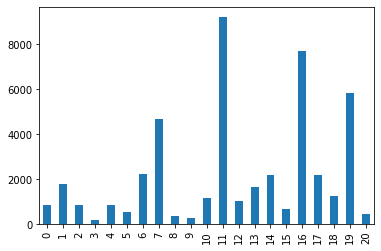

In [1]:
import pandas as pd
import timeit
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping

from PanelInputDataGenerator import PanelInputDataGenerator
from Metrics import turn_predictions_into_binaries, plot_multilabel_pr_curve, create_classification_report_custom_binary_threshold,call_all_training_plots
from Models import *

products_and_features_table = pd.read_pickle('raw_data_1728678rows_x_77columns.pkl')

csa_data = PanelInputDataGenerator(products_and_features_table)
csa_data.create_input_data()
input_data = csa_data.get_input_data()
for input_data_key in input_data.keys():
    print(input_data_key, input_data[input_data_key].shape)
print(csa_data.time_windows)
pd.DataFrame(input_data['Y_train']).apply(
    pd.Series.value_counts).loc[1].plot(kind='bar')

In [2]:
pre_tuner = keras_tuner.RandomSearch(
    build_lstm_for_tuning_rmsprop_generic,
    objective=keras_tuner.Objective("val_true_positives", direction="max"),
    max_trials=999,executions_per_trial=5,overwrite=True)
pre_tuner.search(input_data['X_train'], input_data['Y_train'], epochs=200, batch_size=512, 
             validation_data=(input_data['X_valid'], input_data['Y_valid']),
             callbacks=[tf.keras.callbacks.TensorBoard("/tmp/tb_logs"),
                        EarlyStopping(monitor="val_true_positives",mode='max', patience=5, restore_best_weights=True,verbose=1)])

Trial 5 Complete [00h 08m 43s]
val_true_positives: 4369.2

Best val_true_positives So Far: 4369.2
Total elapsed time: 00h 37m 03s
INFO:tensorflow:Oracle triggered exit


In [3]:
pre_tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
neurons first layer: 512
learning_rate: 0.005
momentum: 0.9
epsilon: 1e-06
Score: 4369.2


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1533952   
                                                                 
 dense (Dense)               (None, 21)                10773     
                                                                 
Total params: 1,544,725
Trainable params: 1,544,725
Non-trainable params: 0
_________________________________________________________________
                                 precision    recall  f1-score  support
Asset Management                  0.742574  0.496689  0.595238    151.0
Aval                              0.524096  0.302083  0.383260    288.0
Betriebliche Altersvorsorge       0.633588  0.592857  0.612546    140.0
Bond-Emissionen                   0.750000  0.066667  0.122449     45.0
Bürgschaften und Garantien        0.500000  0.017964  0.034682    167.0
Cash Pooli

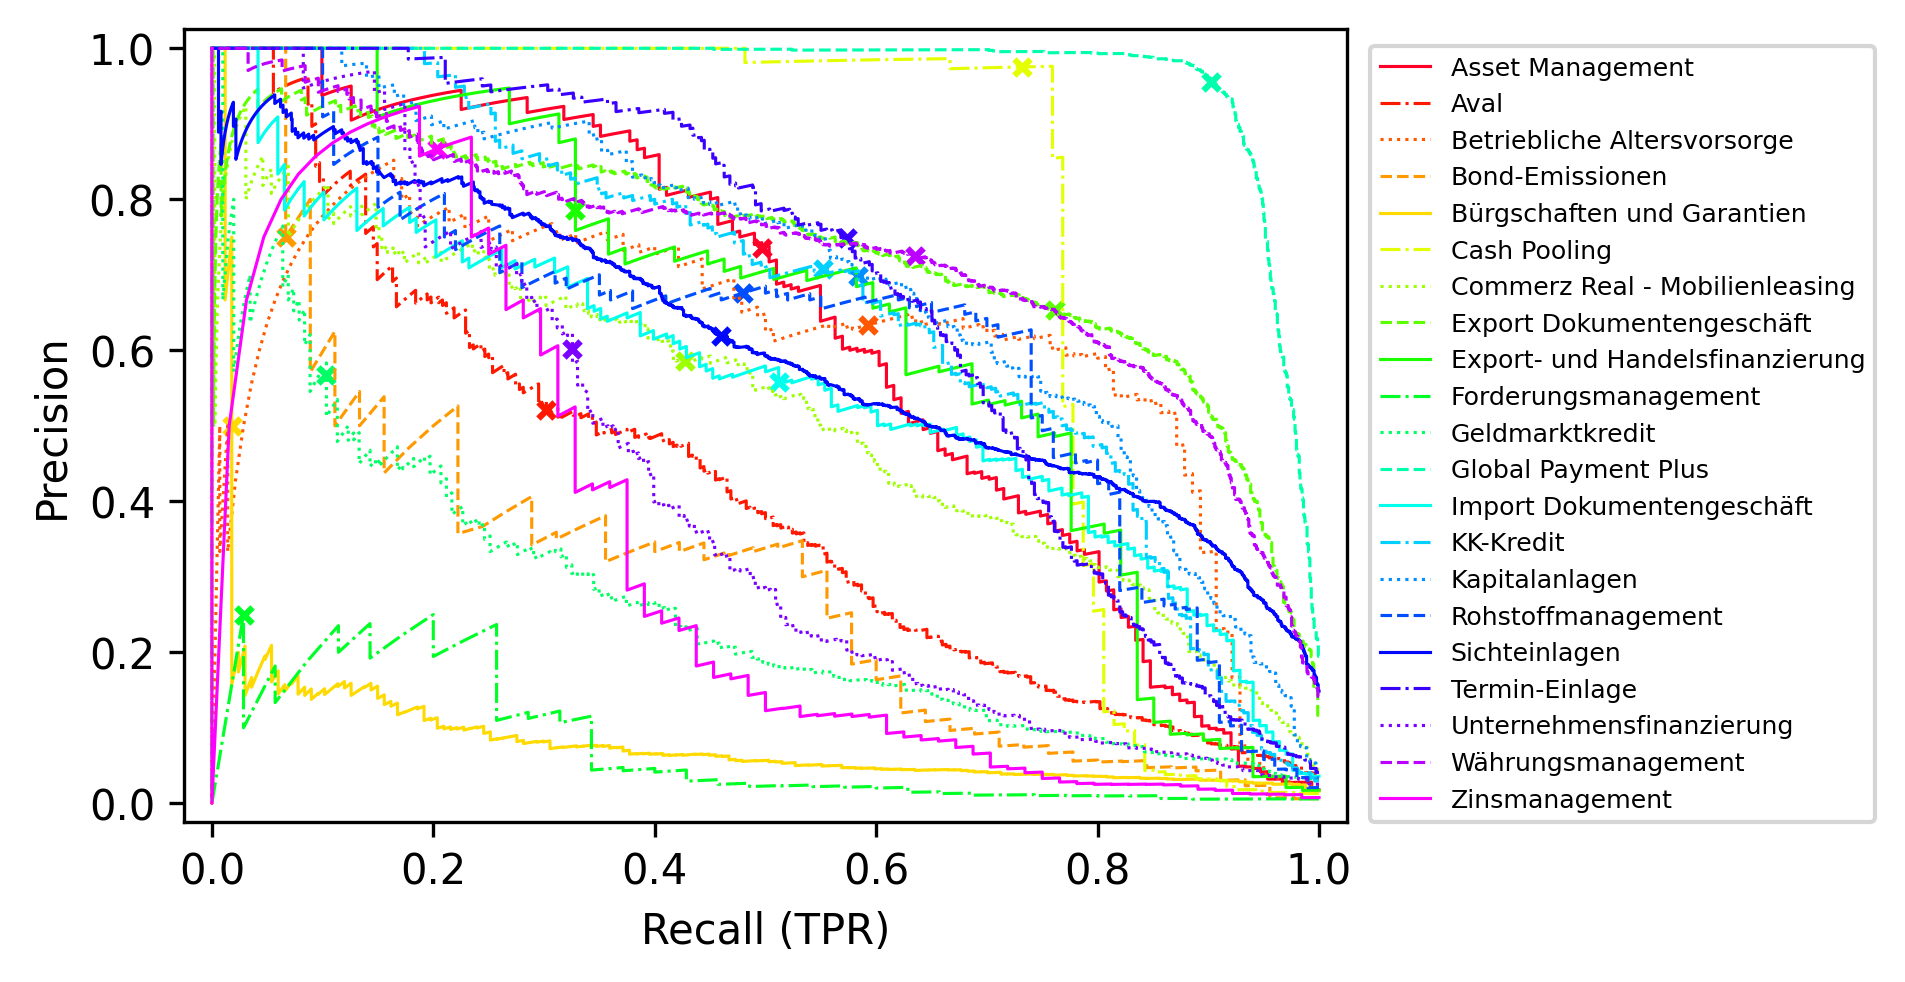

In [4]:
position = 1
best_model = pre_tuner.get_best_models(num_models=position)[position-1]
best_model.summary()
report_panel_approach = create_classification_report_custom_binary_threshold(
    turn_predictions_into_binaries(best_model.predict(input_data['X_test']), 0.5),
    input_data['Y_test'],csa_data.all_products)
print(report_panel_approach[["precision","recall","f1-score","support"]])
report_panel_approach.to_pickle("classification_report_panel_approach.pkl")
plot_multilabel_pr_curve(best_model.predict(input_data['X_test']),input_data['Y_test'],csa_data.all_products,"pr_curve_panel_approach.png")